# Predicting Long-Term Mortality: Evidence from the Health and Retirement Study

### Yiang Li

### S0. problem formulation

#### Background:

The current academic literature in predicting mortality has extensively focused on disease and frailty, although social, behavioral, and psychological statuses may herald broad physiological decline. I tested the effectiveness of the machine learning algorithms on the NSHAP sample in Project 1 and learnt the important features predicting mortality. This project will extend the analysis by 1) using a different set of predictors 2) applying some new algorithms in addition to tree-based algorithm 3) using a different dataset.

#### Context:

Health and Retirement Survey (HRS) is a nationally representative survey of the older US adults (aged 50-61) collected every two years from 1992 to 2018. I use 2002 characteristics as baseline and 2016 disposition status (reported in the 2018 wave) as target (n = 20218). The choice of the baseline year of 2002 is because the 2002 wave is the first wave of the HRS that have consistent and detailed health-related measurements. 

#### Goal
The goal of this project is to predict mortality in the next 14 years using the baseline characteristics in 2002. I will also discussed the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms. The findings will serve important purposes for public health practitioners in understanding the risk and protective factors of mortality in the aging process.

#### Task: 
The task is to train a supervized binary classification model to predict mortality in the next 14 years using the baseline characteristics in 2002.

#### Dataset Links:
<a href= "https://hrs.isr.umich.edu/sites/default/files/meta/2002/core/codebook/h02_00.html?_ga=2.14020593.714056361.1676427746-1610833755.1676427746">Codebook</a>

<a href= "https://hrs.isr.umich.edu/data-products">Dataset</a>

#### List of features I will be using:
1. Body mass index: HRS: HC139 - weight in pounds (continuous)
2. Hypertension: HRS: HC005 (binary)
3. Diabetes: HRS: HC010 (binary)
4. Self-rated health: HRS: HC001 (ordinal)
5. Arthritis: HRS: HC070 (binary)
6. Smoking: HRS: HC117 (binary)
7. Drunk alcohol: HRS: HC128 (binary)
8. Age at baseline: HRS: HX067_R (ordinal, year of birth)
9. Education: HRS: HB014A (ordinal)
10. Net household assets: HRS: HC134 + HQ331 + HQ376 (continuous)
11. Marital status: HRS: HMARITAL (binary)
12. Sex: HRS: HX060_R (binary)
13. Race: HRS: HB031A (binary)
14. Religion Importance:  HRS: HB053 (ordinal)
15. Children co-residence: HRS: HE012 (binary)
16. Grandchildren: HRS: HE046 (ordinal)
17. Relatives: HRS: HF174 (binary)
18. Volunteer: HRS: HG092 (binary)
19. Friends: HRS: HF176 (ordinal)
20. Functional limitations: HRS: HG001 (binary)

#### Import packages for the analysis

In [38]:
# Data Preprocessing package
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Machine Learning package
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
import joblib # save gridsearch model
import warnings
warnings.filterwarnings('ignore')
seed = 42

### S1: Exploratory Data Analysis & Data Preprocessing

Because the HRS dataset of each wave (e.g., 2002) is stored in 20+ files (in multiple formats), I first need to merge the files into one dataframe. The following code is used to merge the files. I used the CSV version of the HRS raw dataset.

Then, I have concatenated the disposition statuses of the 8 subsequent waves since 2002 until 2018 to create a new variable called "disposition" that indicates the status of the respondents in 2018. The disposition status is coded as 0 (alive) and 1 (dead) in the new variable. Those not in the disposition datasets are still alive.

In [2]:
# Import all the core files in the baseline wave 2002
all_core_files = glob.glob('hrs_data/*.csv')
# Create an empty dataframe to concatenate with all the dataframes
core_data_raw = pd.DataFrame()
# Loop through all the files and read them into a dataframe
for filename in all_core_files:
    dfcore = pd.read_csv(filename, index_col=None, header=0)
    col_to_merge = dfcore.columns.difference(core_data_raw.columns)
    if filename.endswith('R.csv'):
        core_data_raw = pd.concat([core_data_raw, dfcore[col_to_merge]], axis=1)
    elif filename.endswith('H.csv'):
        dfmerge = pd.concat([dfcore[col_to_merge], dfcore['HHID']], axis=1)
        core_data_raw = core_data_raw.merge(dfmerge,
                                            on=["HHID"], how="inner")
# Select the columns we need
core_data = core_data_raw[['HHID', 'PN',
                           'HC139', 'HC005', 'HC010', 'HC001', 'HC070',
                           'HC117', 'HC128', 'HX067_R', 'HB014A', 'HC134', 'HQ331', 'HQ376', 'HMARITAL', 'HX060_R',
                           'HB031A',
                           'HB053', 'HE012', 'HE046', 'HF174', 'HG092', 'HF176',
                           'HG001'
                           ]]
# Show the first 5 rows of the dataframe
core_data.head()

,HHID,PN,HC139,HC005,HC010,HC001,HC070,HC117,HC128,HX067_R,...,HMARITAL,HX060_R,HB031A,HB053,HE012,HE046,HF174,HG092,HF176,HG001
0,3,10,170.0,5.0,5.0,3.0,5.0,5.0,1.0,1936.0,...,1.0,1.0,1.0,1,5.0,12.0,5.0,20.0,1.0,5.0
1,3,20,179.0,5.0,5.0,3.0,1.0,5.0,5.0,1938.0,...,1.0,2.0,1.0,1,5.0,12.0,5.0,100.0,1.0,5.0
2,10001,10,180.0,5.0,5.0,2.0,5.0,5.0,5.0,1939.0,...,6.0,1.0,1.0,3,NaN,NaN,5.0,9998.0,3.0,5.0
3,10003,30,120.0,1.0,5.0,1.0,5.0,5.0,5.0,1956.0,...,5.0,2.0,1.0,1,NaN,NaN,5.0,0.0,0.0,5.0
4,10004,10,230.0,1.0,5.0,2.0,1.0,5.0,1.0,1939.0,...,1.0,1.0,1.0,1,1.0,95.0,1.0,200.0,1.0,5.0


In [3]:
# Importing all disposition files of every wave
all_dispositon_files = glob.glob('hrs_data/disposition/*.csv')
# Create an empty dataframe to store all the dataframes
dispositon_data_full = pd.DataFrame()
# Loop through all the files and read them into a list of dataframes
for filename in all_dispositon_files:
    df_disposition = pd.read_csv(filename, index_col=None, header=0)
    dispositon_data_full = pd.concat([dispositon_data_full, df_disposition], axis=0, ignore_index=True)
# Concatenate all the dataframes into one dataframe
dispositon_data = dispositon_data_full.iloc[:, :2].copy()
# As these are all the disposition files, we can set deceased to 1
dispositon_data['deceased'] = 1
dispositon_data

,HHID,PN,deceased
0,10475,10,1
1,10592,10,1
2,11219,10,1
3,11575,20,1
4,11626,10,1
...,...,...,...
10027,213379,10,1
10028,213410,10,1
10029,213418,10,1
10030,213428,10,1


After getting the 2002 core dataset and the disposition dataset, I merged the two datasets on the unique identifier "id" to create the final dataset for the analysis.

Then, I have checked whether the outcome variable is balanced. Different from the NSHAP dataset that Zejian and I used in Project 1, the HRS dataset is pretty balaced with 54.3% of the respondents alive and 45.7% of the respondents dead. Hence, working with the balanced dataset allows the machine learning algorithms to learn the patterns of the predictors better on both the alive and deceased classes.

In [4]:
# Merge the core data with the disposition data
df02_d = core_data.merge(dispositon_data, on=["HHID", "PN"], how="left")
# Fill the respondents not appearing in the disposition data as not deceased
df02_d['deceased'] = df02_d['deceased'].fillna(0)
# Show the breakdown of deceased and not deceased
df02_d['deceased'].value_counts()

0.0    10973
1.0     9245
Name: deceased, dtype: int64

In [5]:
#check the data size and display the top 5 rows
df02_d.shape, display(df02_d.head())

,HHID,PN,HC139,HC005,HC010,HC001,HC070,HC117,HC128,HX067_R,...,HX060_R,HB031A,HB053,HE012,HE046,HF174,HG092,HF176,HG001,deceased
0,3,10,170.0,5.0,5.0,3.0,5.0,5.0,1.0,1936.0,...,1.0,1.0,1,5.0,12.0,5.0,20.0,1.0,5.0,1.0
1,3,20,179.0,5.0,5.0,3.0,1.0,5.0,5.0,1938.0,...,2.0,1.0,1,5.0,12.0,5.0,100.0,1.0,5.0,1.0
2,10001,10,180.0,5.0,5.0,2.0,5.0,5.0,5.0,1939.0,...,1.0,1.0,3,NaN,NaN,5.0,9998.0,3.0,5.0,0.0
3,10003,30,120.0,1.0,5.0,1.0,5.0,5.0,5.0,1956.0,...,2.0,1.0,1,NaN,NaN,5.0,0.0,0.0,5.0,0.0
4,10004,10,230.0,1.0,5.0,2.0,1.0,5.0,1.0,1939.0,...,1.0,1.0,1,1.0,95.0,1.0,200.0,1.0,5.0,1.0


((20218, 25), None)

After checking the balance of the outcome variable and the missingness of the predictors, I will go ahead to preprocess the data for the analysis by 1) imputing the missing values separately for continuous and categorical variables 2) construct some variables based on multiple other variables 3) scaling the continuous variables.

##### **Preprocessing the continuous/ordinal variables**
Here I first preprocess special ordinal variables: household asset and age. Then I scale the continuous variables of household asset using the standard scaler. Finally, I address the missing values of the continuous variables. They are either codes as NA or coded as impractical numbers e.g., 9, 99, 999, 9999, etc. I impute the missing values of the continuous variables using the mean imputation method. I have also set the column names of the continuous variables for the convenience of the analysis.

We see from the descriptive statistics of the continuous variables that they do make sense in reality, except age. There are some very young respondents in a longitidunal study representing US older adults. I will later fix it and provide the reason for the outliers.

In [6]:
# select the continuous and ordinal variables
con_col = ['HC139', 'HC001', 'HB014A', 'HB053', 'HE046', 'HG092', 'HF176',
           'HX067_R', 'HC134', 'HQ331', 'HQ376']
# Create a new dataframe with only continuous/ordinal variables
df02_d_ord = df02_d[con_col].copy()
# Construct the household asset variable
wealth_col = ['HC134', 'HQ331', 'HQ376']
for col in wealth_col:
    # Set values of no wealth to 0
    df02_d_ord[col] = df02_d_ord[col].replace(np.nan, 0)
df02_d_ord['wealth_amt'] = df02_d_ord['HC134'] + df02_d_ord['HQ331'] + df02_d_ord['HQ376']
# Scale the wealth variable to 0-100
scaler = MinMaxScaler(feature_range=(0, 100))
df02_d_ord['wealth_amt'] = scaler.fit_transform(df02_d_ord['wealth_amt'].values.reshape(-1, 1))
df02_d_ord.drop(['HC134', 'HQ331', 'HQ376'], axis=1, inplace=True)
# Construct the age variable
df02_d_ord['age'] = 2002 - df02_d_ord['HX067_R']
df02_d_ord.drop(['HX067_R'], axis=1, inplace=True)
# Set values of missing ordinal variables originally coded as negative to nan
df02_d_ord[df02_d_ord < 0] = np.nan
for i in df02_d_ord.columns:
    if max(df02_d_ord[i]) == 9999:
        df02_d_ord[i] = df02_d_ord[i].replace([9999, 9998], np.nan)
    elif max(df02_d_ord[i]) == 999:
        df02_d_ord[i] = df02_d_ord[i].replace([999, 998], np.nan)
    elif max(df02_d_ord[i]) == 99:
        df02_d_ord[i] = df02_d_ord[i].replace([99, 98, 97, 95], np.nan)
    elif max(df02_d_ord[i]) == 9:
        df02_d_ord[i] = df02_d_ord[i].replace([9, 8], np.nan)
# Check the number of missing values in original ordinal variables
df02_d_ord_nona = df02_d_ord.dropna()
print("Filled {} respondents' missing ordinal variables by mean".format(len(df02_d_ord) - len(df02_d_ord_nona)))
# Fill the missing values with the mean of the variable
df02_d_ord.fillna(df02_d_ord.mean(), inplace=True)
# Name the columns
df02_d_ord.columns = ['Weight (Pounds)', 'Self-Rated Health', 'Education Yrs',
                      'Religion Importance', 'Number of Grandchildren',
                      'Hours of Volunteering', 'Number of Times Socializing',
                      'Wealth', 'Age'
                      ]
# Get the summary statistics of the ordinal variables
df02_d_ord.describe()

Filled 9043 respondents' missing ordinal variables by mean


,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age
count,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000,20218.000000
mean,171.296493,2.868444,12.100723,1.905974,6.657524,45.703950,1.406329,2.767061,68.788793
std,38.282986,1.112213,3.363827,1.359676,5.093500,165.001137,5.934359,12.135002,9.954431
min,65.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,26.000000
25%,145.000000,2.000000,11.000000,1.000000,3.000000,0.000000,1.000000,0.000000,62.000000
50%,170.000000,3.000000,12.000000,1.000000,6.657524,10.000000,1.000000,0.000000,68.788793
75%,192.000000,4.000000,14.000000,3.000000,7.000000,45.703950,2.000000,0.000000,75.000000
max,400.000000,5.000000,17.000000,5.000000,77.000000,9000.000000,365.000000,100.000000,110.000000


Then, I check the correlation between continuous variables in the dataset. Given that there is no strong correlation between the continuous variables, I do not need to drop any of the continuous variables.

Among the correlations, there is a negative correlation of 0.2 between years of education and number of grandchildren. This is because the number of grandchildren is only available for those who have children and the number of children is positively correlated with years of education. Therefore, the number of grandchildren is negatively correlated with years of education. However, the correlation is not strong enough to drop either of the two variables.

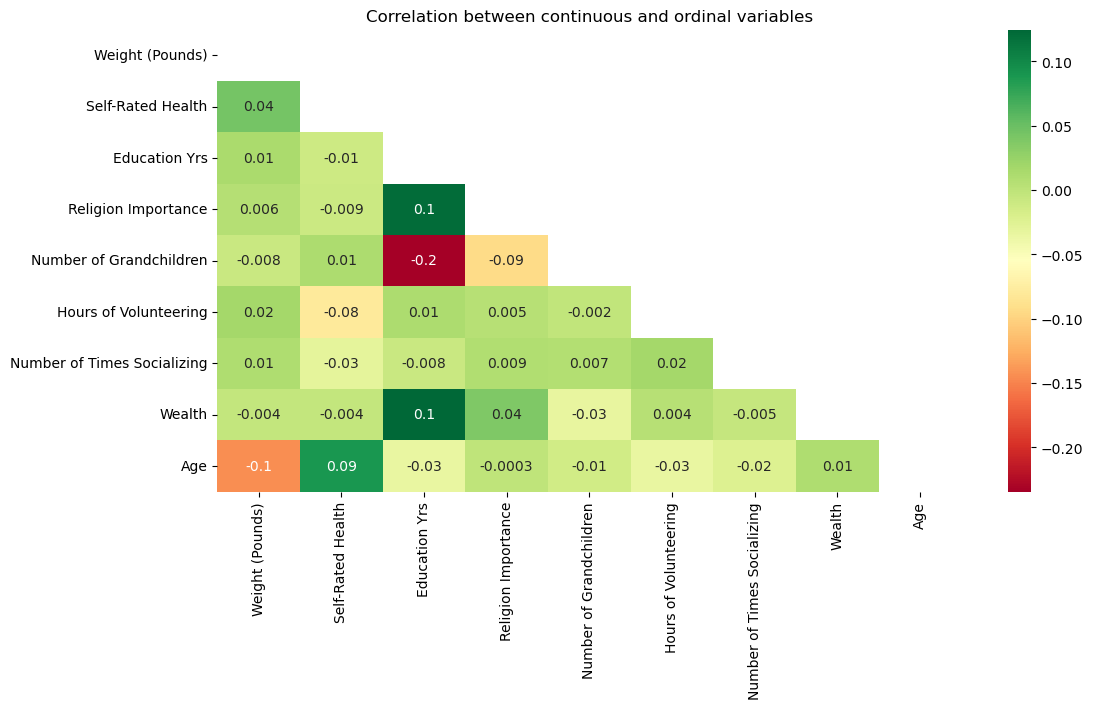

In [7]:
# Analyze the correlation amongst the continuous and ordinal variables
_, ax = plt.subplots(figsize=(12, 6))
# Create a mask to hide the upper triangle of the heatmap
matrix = np.triu(df02_d_ord.corr())
# Plot the heatmap
sns.heatmap(df02_d_ord.corr(), annot=True, fmt='.1g', cmap='RdYlGn', ax=ax,
            mask=matrix)
plt.title('Correlation between continuous and ordinal variables')
plt.show()

##### **Preprocessing the binary variables**
I also preprocess the binary variables in the dataset. 

First, I construct some binary variables based on categorical responses: whether the respondent has hypertension, diabetes, arthritis, smoking, drunk alcohol, married, children nearby, relatives nearby, and functional limitations. This is because HRS initially records the responses in high accuracy for nuances sociological research purposes. The category of 1 and 3 in the first 3 varaibles indicate "Yes" and "Disputes previous wave record, but now has condition". Here, we treat both of them as "Yes". In the other cases, the category of 1 indicates Yes and 3 or 5 indicates Ever Had and No respectively. Here, we also treat them as Yes and No.

Then, I address the missing values of the binary variables. They are coded as NA. I impute the missing values of the binary variables using the mode imputation method. I have also set the column names of the binary variables for the convenience of the analysis.

In [8]:
# Preprocessing the binary/categorical variables
cat_col = ['HC005', 'HC010', 'HC070', 'HC117', 'HC128', 'HMARITAL', 'HE012',
           'HF174', 'HG001',
           'HX060_R', 'HB031A']
df02_d_cat = df02_d[cat_col].copy()
# Check the number of missing values in original categorical variables
print("Missing values in the columns", "\n", df02_d_cat.isnull().sum())
# Fill the missing values with the mode of the variable
df02_d_cat.fillna(df02_d_cat.mode().iloc[0], inplace=True)
# Dichotomize the categorical variables
for i in cat_col[:3]:
    df02_d_cat[i] = df02_d_cat[i].isin([1, 3])
for i in cat_col[3:11]:
    df02_d_cat[i] = df02_d_cat[i].isin([1])
# Name the columns
df02_d_cat.columns = ['Hypertension', 'Diabetes', 'Arthritis', 'Smoking',
                      'Drunk Alcohol', 'Married', 'Children Nearby',
                      'Relatives Nearby', 'Functional Limitations',
                      'Sex_Male', 'Race_White']
df02_d_cat

Missing values in the columns 
 HC005        663
HC010        663
HC070        663
HC117        786
HC128        663
HMARITAL       1
HE012       2107
HF174        669
HG001        671
HX060_R     2051
HB031A        41
dtype: int64


,Hypertension,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex_Male,Race_White
0,False,False,False,False,True,True,False,False,False,True,True
1,False,False,True,False,False,True,False,False,False,False,True
2,False,False,False,False,False,False,True,False,False,True,True
3,True,False,False,False,False,False,True,False,False,False,True
4,True,False,True,False,True,True,True,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
20213,True,False,True,False,False,False,True,False,False,False,True
20214,True,False,True,False,False,False,True,False,False,False,True
20215,True,False,True,False,False,False,False,False,False,False,False
20216,True,False,True,False,False,True,True,False,False,False,True


From the earlier descriptive statistics in cleaning continuous variables, I see that the variable <code>age</code> variable includes the respondents aged below 51. This is because HRS sample collection is based on the households and include the spouse or partner of the main household respondent whose age may below 51. I will remove the respondents aged below 51 in the data cleaning process because they will bias the analysis. 

In [9]:
# Concatenate the continuous/ordinal and categorical variables
hrs_clean_full = pd.concat([df02_d['deceased'], df02_d_ord, df02_d_cat], axis=1)
# Select the respondents aged 51 and above
hrs_clean = hrs_clean_full[hrs_clean_full['Age'] >= 51]
hrs_clean

,deceased,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age,...,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex_Male,Race_White
0,1.0,170.000000,3.000000,12.0,1.0,12.000000,20.00000,1.000000,0.0,66.000000,...,False,False,False,True,True,False,False,False,True,True
1,1.0,179.000000,3.000000,16.0,1.0,12.000000,100.00000,1.000000,0.0,64.000000,...,False,True,False,False,True,False,False,False,False,True
2,0.0,180.000000,2.000000,12.0,3.0,6.657524,45.70395,3.000000,0.0,63.000000,...,False,False,False,False,False,True,False,False,True,True
4,1.0,230.000000,2.000000,16.0,1.0,6.657524,200.00000,1.000000,0.0,63.000000,...,False,True,False,True,True,True,True,False,True,True
5,0.0,155.000000,1.000000,12.0,1.0,6.657524,40.00000,1.000000,0.0,56.000000,...,False,False,False,True,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20213,0.0,171.296493,2.868444,0.0,1.0,20.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,True,False,False,False,True
20214,0.0,171.296493,2.868444,14.0,1.0,2.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,True,False,False,False,True
20215,1.0,171.296493,2.868444,12.0,3.0,8.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,False,False,False,False,False,False
20216,1.0,171.296493,2.868444,15.0,5.0,2.000000,45.70395,1.406329,0.0,68.788793,...,False,True,False,False,True,True,False,False,False,True


In [10]:
# Save the cleaned data
hrs_clean.to_csv('hrs_clean.csv', index=False)

### S2: Pipeline: Feature Selection, Parameter Tuning, and Model Training

Now, moving on to the machine learning part of the analysis. I will first use the pipeline to select the features, tune the parameters, and validate the data. The pipeline will be used to train the following algorithms: logistic regression, neural network, and KNN.

First, I split the sample into training and testing data with shuffle that allows the random permutations. BY doing so, I try to prevent the knowledge leakage from test dataset during the process of feature selection and parameter tuning. I will use the training dataset to select the features and tune the parameters. Then, I will use the testing dataset to validate the model performance.

In [11]:
hrs_df = pd.read_csv('hrs_clean.csv')

# Split the data into training, validation, and test sets
y_df = hrs_df[['deceased']]
X_df = hrs_df.drop(columns=['deceased'], inplace=False)
X_train_v, X_test, y_train_v, y_test = train_test_split(X_df, y_df,
                                                        test_size=0.2,
                                                        random_state=seed,
                                                        shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v,
                                                  test_size=0.25,
                                                  random_state=seed,
                                                  shuffle=True)

# check the data size after splitting
print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)
print("y_train size: ", y_train.shape)
print("y_test size: ", y_test.shape)

X_train size:  (11856, 20)
X_test size:  (3953, 20)
y_train size:  (11856, 1)
y_test size:  (3953, 1)


After splitting the dataset, there are 15809 observations in the training dataset and 3953 observations in the testing dataset.

The variable distribution shows a similar distribution between the training and testing datasets and the outcome variable is roughly balanced in both datasets.

In [12]:
# check the distribution of the target variable in the train and test data
print("y_train distribution: \n", y_train['deceased'].value_counts())
print("y_test distribution: \n", y_test['deceased'].value_counts())

y_train distribution: 
 0.0    6414
1.0    5442
Name: deceased, dtype: int64
y_test distribution: 
 0.0    2115
1.0    1838
Name: deceased, dtype: int64


##### **Hyperparameter tuning for logistic regression**
In the logistic regression, the model performance on the training set increases by the value of c, controlling for the type of regularization used. This is because the larger the value of c, the less regularization penalizing model complexity is applied to the model and more weight is given to maximize the loss. Hence, the model fits the data better, but might result in overfitting. The model with no penalty has the highest $R^2$ score because it has no regularization and thus fits the data best. 

Controlling for c, the model with L1 penalty has the lowest $R^2$ score because it has L1 regularization that results in sparse models with many coefficients being zero. The model with L2 penalty results in many non-zero coefficients in similar magnitude. For this dataset, L2 regularization results in a better model performance than L1 regularization.

Hence, I need to balance the model performance and model complexity (i.e., bias-variance trade-off). To do so, I will use the gridsearch CV with 5-fold cross validation to test on different values of c and the type of regularization. The gridsearch CV will return the best model with the best parameters based on one of the four metrics: accuracy, precision, recall, and F1 score. For the relatively balanced dataset, I will primarily use the F1 score as the metric to evaluate the model performance as it is the harmonic mean of precision and recall and intuitively captures the concept of classifying the deceased and alive classes correctly. Parameters that maximized the performance in terms of other measures will also be considered, especially if the parameters are different to the ones selected by the F1 score.

In [13]:
# Parameters for the grid search on logistic regression
parameters = [{'penalty': ['l1', 'l2'],
               'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 2, 3, 4, 5, 6, 7, 8]}]
# Evaluation metrics
scores = {"precision": make_scorer(precision_score, zero_division=0),
          "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

# Create a dictionary to store the grid search results
records_lr = dict()

# Loop through the evaluation metrics
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    #Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(LogisticRegression(random_state=seed, solver='liblinear',
                                          max_iter=1000),
                       parameters, cv=5, scoring=score, n_jobs=-1)
    #Doing 5-fold cross validation on the training set
    clf.fit(X_train, np.ravel(y_train))
    #Print the best parameters and the corresponding score
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_lr[score] = clf

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(X_val)

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()

# Tuning hyper-parameters for precision


/opt/anaconda3/envs/MACS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/MACS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/MACS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/MACS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:

Best parameters set found on development set:
{'C': 5, 'penalty': 'l2'}
Grid scores on development set:

0.000 (+/-0.000) for {'C': 1e-05, 'penalty': 'l1'}
0.588 (+/-0.021) for {'C': 1e-05, 'penalty': 'l2'}
0.000 (+/-0.000) for {'C': 0.0001, 'penalty': 'l1'}
0.610 (+/-0.023) for {'C': 0.0001, 'penalty': 'l2'}
0.608 (+/-0.023) for {'C': 0.001, 'penalty': 'l1'}
0.625 (+/-0.028) for {'C': 0.001, 'penalty': 'l2'}
0.621 (+/-0.024) for {'C': 0.01, 'penalty': 'l1'}
0.625 (+/-0.011) for {'C': 0.01, 'penalty': 'l2'}
0.624 (+/-0.016) for {'C': 0.1, 'penalty': 'l1'}
0.623 (+/-0.014) for {'C': 0.1, 'penalty': 'l2'}
0.625 (+/-0.016) for {'C': 1.0, 'penalty': 'l1'}
0.625 (+/-0.017) for {'C': 1.0, 'penalty': 'l2'}
0.625 (+/-0.016) for {'C': 2, 'penalty': 'l1'}
0.625 (+/-0.017) for {'C': 2, 'penalty': 'l2'}
0.625 (+/-0.016) for {'C': 3, 'penalty': 'l1'}
0.625 (+/-0.016) for {'C': 3, 'penalty': 'l2'}
0.625 (+/-0.016) for {'C': 4, 'penalty': 'l1'}
0.625 (+/-0.016) for {'C': 4, 'penalty': 'l2'}
0.625 (+/

Based on the gridsearch CV, the best model has the following parameters: {'C': 6, 'penalty': 'l2'} with F1 score of 0.67 for the alive class and 0.54 for the deceased class. The model performance is not bad, but it is not great either because the average F1 score is 0.67, which is not close to 1.

If using the parameters of the best model measured by other performance metrics, the results are similar. The parameter of {'C': 5, 'penalty': 'l2'} and {'C': 2, 'penalty': 'l2'} maximizes the precision and recall respectively and achieves similar F1 scores. However, when maximizing the Area Under the Curve (AUC), the best model has the parameters of {'C': 0.1, 'penalty': 'l2'}.

Given the difference between two parameters when using the metric of F1 and AUC, I will check the model performance on the testing dataset using both parameters and see which one suffers from less overfitting.

They are:
{'C': 6, 'penalty': 'l2'} and {'C': 0.1, 'penalty': 'l2'}

##### **Hyperparameter tuning for neural network**
Neural network is a powerful machine learning algorithm that can learn the complex patterns of the predictors. However, it is also prone to overfitting. Therefore, I need to tune the hyperparameters of the neural network to prevent overfitting.

The hidden layer size is the number of neurons in the hidden layer. The larger the number of neurons, the more complex the model can be. However, the larger the number of neurons, the more likely the model is to overfit.

The activation function is the function that transforms the input to the output. The activation function is applied to the weighted sum of the inputs and the bias. The different activation functions have different properties. For example, the identity function is linear and the relu function is non-linear. The relu function is the most commonly used activation function in neural networks. It is non-linear and can avoid the vanishing gradient problem.

The alpha is the regularization parameter. It controls the strength of the regularization. The larger the alpha, the more regularization is applied to the model and the less complex the model is. The smaller the alpha, the less regularization is applied to the model and the more complex the model is.

The learning rate is the step size of the gradient descent algorithm. The larger the learning rate, the faster the model converges to the optimal solution. However, the larger the learning rate, the more likely the model is to overshoot the optimal solution and diverge. The smaller the learning rate, the slower the model converges to the optimal solution. However, the smaller the learning rate, the less likely the model is to overshoot the optimal solution and diverge.

Again, when tuning the hyperparameters, I need to balance the model performance and model complexity (i.e., bias-variance trade-off). To do so, I will use the gridsearch CV with 5-fold cross validation to test on different values of the hyperparameters. The gridsearch CV will return the best model with the best parameters based on one of the four metrics: accuracy, precision, recall, and F1 score. For the relatively balanced dataset, I will primarily use the F1 score as the metric to evaluate the model performance as it is the harmonic mean of precision and recall and intuitively captures the concept of classifying the deceased and alive classes correctly. Parameters that maximized the performance in terms of other measures will also be considered, especially if the parameters are different to the ones selected by the F1 score.

The solver is set as default adam because it is the most commonly used solver for neural networks. The solver is the algorithm that is used to minimize the loss function. The adam solver is a variant of the stochastic gradient descent algorithm. It is a combination of the adaptive gradient algorithm and the root mean square propagation algorithm. The adaptive gradient algorithm adjusts the learning rate for each parameter based on the gradients of the loss function. The root mean square propagation algorithm adjusts the learning rate for each parameter based on the average of the squares of the gradients of the loss function. The adam solver is a combination of the adaptive gradient algorithm and the root mean square propagation algorithm. It adjusts the learning rate for each parameter based on both the gradients of the loss function and the average of the squares of the gradients of the loss function. The adam solver is the most commonly used solver for neural networks because it is fast and robust.

# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.001}
Grid scores on development set:

0.542 (+/-0.019) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 1e-05}
0.592 (+/-0.025) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.0001}
0.626 (+/-0.038) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001}
0.562 (+/-0.021) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 1e-05}
0.624 (+/-0.028) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.0001}
0.642 (+/-0.138) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001}
0.606 (+/-0.023) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_s

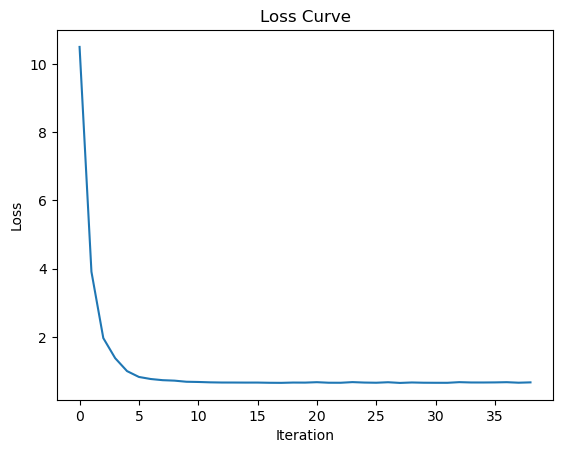

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Grid scores on development set:

0.472 (+/-0.044) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 1e-05}
0.498 (+/-0.055) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.0001}
0.485 (+/-0.102) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001}
0.481 (+/-0.034) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 1e-05}
0.481 (+/-0.120) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.0001}
0.449 (+/-0.372) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001}
0.471 (+/-0.076) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_size

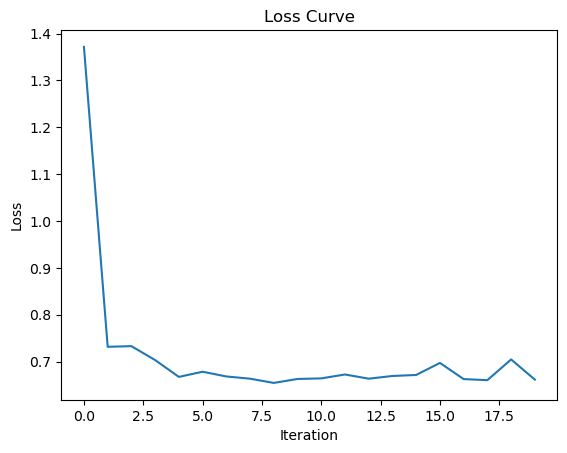

# Tuning hyper-parameters for f1
Best parameters set found on development set:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Grid scores on development set:

0.504 (+/-0.031) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 1e-05}
0.540 (+/-0.035) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.0001}
0.544 (+/-0.051) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001}
0.518 (+/-0.024) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 1e-05}
0.540 (+/-0.072) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.0001}
0.494 (+/-0.203) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001}
0.529 (+/-0.043) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': 

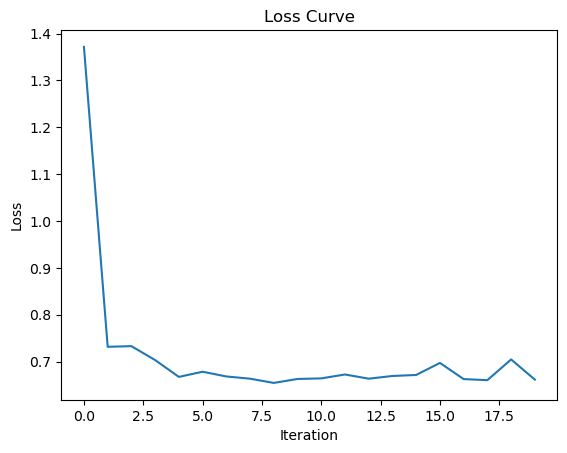

# Tuning hyper-parameters for roc_auc
Best parameters set found on development set:
{'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001}
Grid scores on development set:

0.596 (+/-0.012) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 1e-05}
0.644 (+/-0.016) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.0001}
0.670 (+/-0.021) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001}
0.616 (+/-0.016) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 1e-05}
0.668 (+/-0.013) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.0001}
0.664 (+/-0.023) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001}
0.656 (+/-0.011) for {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes'

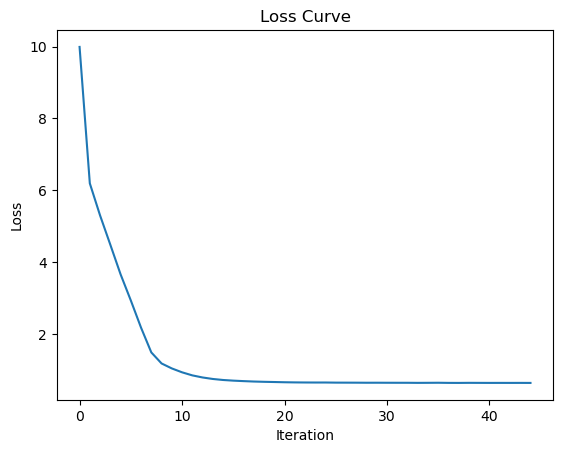

In [14]:
parameters = [{'hidden_layer_sizes': [(1,), (30,), (100,), (10, 5,)],
               'activation': ['identity', 'relu'],
               'alpha': [0, 1e-4, 1e-2],
               'learning_rate_init': [1e-5, 1e-4, 1e-3]
               }]
scores_nn = ['precision', 'recall', 'f1', 'roc_auc']

records_nn = dict()

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    # Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(MLPClassifier(random_state=seed, tol=1e-3, max_iter=1000),
                       parameters, cv=5,
                       scoring=score)
    # Doing 5-fold cross validation on the training set
    clf.fit(X_train, np.ravel(y_train))

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_nn[score] = clf

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(X_val)

    # Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

    print()
    
    print(f"Learning stops at iter num_{clf.best_estimator_.n_iter_}")
    plt.plot(range(clf.best_estimator_.n_iter_), clf.best_estimator_.loss_curve_)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.show()

In [15]:
joblib.dump(records_nn, 'records_nn.pkl')

['records_nn.pkl']

Based on the GridSearch CV, there are three unique best set of parameters for four performance metrics.

{'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.001} is set the of parameters that maximizes the precision. The F1 socre is 0.70 for the alive class and 0.46 for the deceased class. 

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001} is the set of parameters that maximizes the recall and the F1 score. The F1 score is 0.68 for the alive class and 0.50 for the deceased class.

{'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001} is the set of parameters that maximizes the AUC_ROC. The AUC_ROC is 0.670. The F1 score is 0.67 for the alive class and 0.55 for the deceased class.

In addition to testing the performances, I have also plotted the loss curve for each of the best set of parameters. The loss curve is the plot of the loss function against the number of iterations. The loss function is the function that is minimized by the model and the smaller the loss function, the better the model fits the data. The loss curve is a good way to check if the model is overfitting. If the loss curve is smooth and the loss function decreases as the number of iterations increases, the model is not overfitting. If the loss curve is not smooth and the loss function decreases and increases as the number of iterations increases, the model is overfitting.

Based on the four plots, I conclude that the first (maximizes precision) and the fourth (maximizes AUC_ROC) set of parameters are the best as the set of parameters that maximizes recall and F1 score are overfitting with the loss curve not smooth and the loss function decreasing and increasing as the number of iterations increases.

##### **Hyperparameter tuning for KNN**
K Nearest Neighbors (KNN) is a simple machine learning algorithm that classifies the data based on the majority of the nearest neighbors. The KNN algorithm is a non-parametric algorithm that does not make any assumptions about the distribution of the data because it needs to calculate the distance between the test data and all the training data. To make the best choice on the distance measures and whether rely on local or global information, I need to tune the hyperparameters of the KNN algorithm.

I will use the gridsearch CV with 5-fold cross validation to test on different values of the hyperparameters. The gridsearch CV will return the best model with the best parameters based on one of the four metrics: accuracy, precision, recall, and F1 score. For the relatively balanced dataset, I will primarily rely on the F1 score as the metric to evaluate the model performance as it is the harmonic mean of precision and recall and intuitively captures the concept of classifying the deceased and alive classes correctly. Parameters that maximized the performance in terms of other measures will also be considered, especially if the parameters are different to the ones selected by the F1 score.

In [16]:
parameters = [{'n_neighbors': [5, 20, 50],
               'weights': ['uniform', 'distance'],
               'p': [1, 2]
               }]
scores = ['precision', 'recall', 'f1', 'roc_auc']

records_knn = dict()

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    # Construct a grid search object with 5-fold cross validation
    clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), parameters, cv=5,
                       scoring=score)
    # Doing 5-fold cross validation on the training set
    clf.fit(X_train, np.ravel(y_train))

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    records_knn[score] = clf

    # List all performance of all parameters combination
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(X_val)

    #  Print the classification report based on the best parameters
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'n_neighbors': 50, 'p': 1, 'weights': 'uniform'}
Grid scores on development set:

0.565 (+/-0.019) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.571 (+/-0.015) for {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.559 (+/-0.028) for {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.561 (+/-0.029) for {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.616 (+/-0.019) for {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
0.605 (+/-0.011) for {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
0.604 (+/-0.019) for {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
0.593 (+/-0.020) for {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
0.625 (+/-0.019) for {'n_neighbors': 50, 'p': 1, 'weights': 'uniform'}
0.624 (+/-0.020) for {'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
0.616 (+/-0.028) for {'n_neighbors': 50, 'p': 2, 'weights': 'uniform'}
0.615 (+/-0.028) for {'n_neighbors': 50, 'p': 2, 

There are only three types parameters tuned as the best for the KNN algorithm when evaluating based on four performance metrics.

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'} maximizes the model performnace on recall and F1; {'n_neighbors': 50, 'p': 1, 'weights': 'distance'} maximizes the model performnace on AUC_ROC; {'n_neighbors': 50, 'p': 1, 'weights': 'uniform'} maximizes the model performnace on precision

They do not differ significantly in terms of the model performance. Therefore, with the first two sets of parameters achieving similar F1 scores and the third set of parameters achieving slightly worse performance on F1 score in the training set. However, we do not know if the model suffers from overfitting or not.

Therefore, I will try the following two specifications (that are quite different) on the testing dataset to see which one suffers from less overfitting: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'} and {'n_neighbors': 50, 'p': 1, 'weights': 'uniform'}

##### **Conclusion from the model tuning**:

I have selected two sets of parameters for each model.

1. Logistic regression: {'C': 6, 'penalty': 'l2'} that maximizes F1 and {'C': 0.1, 'penalty': 'l2'} that maximizes AUC_ROC.
2. Neural Network: {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.001} that maximizes precision and {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001} that maximizes AUC_ROC.
3. KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'} that maximizes F1 and recall and {'n_neighbors': 50, 'p': 1, 'weights': 'uniform'} that maximizes percision.

### S3: Model Evaluation (On Test Set) and Error Analysis

#### **Model Evaluation**
In the model evaluation section of this pipeline, I will evaluate the performance of the selected models on the testing dataset. I will use the F1 score, precision, recall, and AUC_ROC as the metrics to evaluate the model performance. I will also use the confusion matrix and ROC curve to visualize the model performance.

##### **Model Evaluation on Logistic Regression**

From the accuracy scores and other model performance measures on the testing dataset, I see that the logistic regression model with the parameters {'C': 0.1, 'penalty': 'l2'} performs the best in terms of accuracy score on the test set, indicating less overfitting. Hence, I will use this set of parameters to evaluate the model performance on the test set.

In [17]:
# Take the best model based on the roc_auc score
clf_e_lr0 = records_lr['roc_auc']
# Print the performance on the training set
print("Performence on train set",
      metrics.accuracy_score(clf_e_lr0.predict(X_train), y_train))
# Predict the test set
y_pred_lr0 = pd.DataFrame(clf_e_lr0.predict(X_test), columns=["deceased"])
# Print the performance on the test set
print("Performence on test set", metrics.accuracy_score(y_pred_lr0, y_test))


Performence on train set 0.6346997300944669
Performence on test set 0.6215532506956741


In [18]:
# Take the best model based on the f1 score
clf_e_lr1 = records_lr['f1']
# Print the performance on the training set
print("Performence on train set",
      metrics.accuracy_score(clf_e_lr0.predict(X_train), y_train))
# Predict the test set
y_pred_lr1 = pd.DataFrame(clf_e_lr0.predict(X_test), columns=["deceased"])
# Print the performance on the test set
print("Performence on test set", metrics.accuracy_score(y_pred_lr1, y_test))


Performence on train set 0.6346997300944669
Performence on test set 0.6215532506956741


The classfication report of the best LR model on the test set shows that the model has a high precision and recall on the alive class, but a low precision and recall on the deceased class. The model also has a high F1 score on the deceased class, but a low F1 score on the alive class. This is not ideal as the model is not good at classifying the deceased class, who are my class of interest. Hence, the model features primarily captures the protective factors rather than the risk factors. I will see if the performance gets better in other models

In [19]:
print(metrics.classification_report(y_test, y_pred_lr0))

              precision    recall  f1-score   support

         0.0       0.63      0.71      0.67      2115
         1.0       0.61      0.52      0.56      1838

    accuracy                           0.62      3953
   macro avg       0.62      0.61      0.61      3953
weighted avg       0.62      0.62      0.62      3953



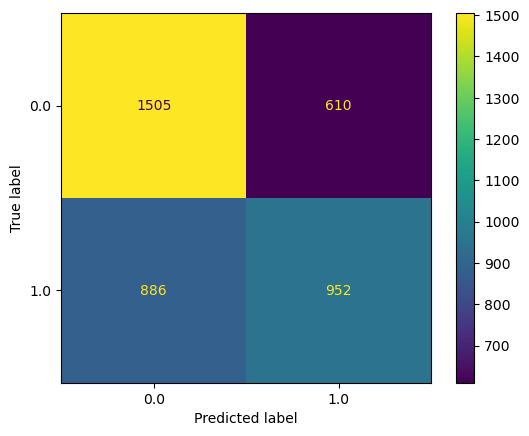

In [20]:
cm_lr0 = metrics.confusion_matrix(y_test, y_pred_lr0)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_lr0,
                                      display_labels=clf_e_lr0.classes_)
disp.plot()

 The model has a high AUC_ROC score, indicating that the model can distinguish the deceased and alive classes well.

0.6642497369686962


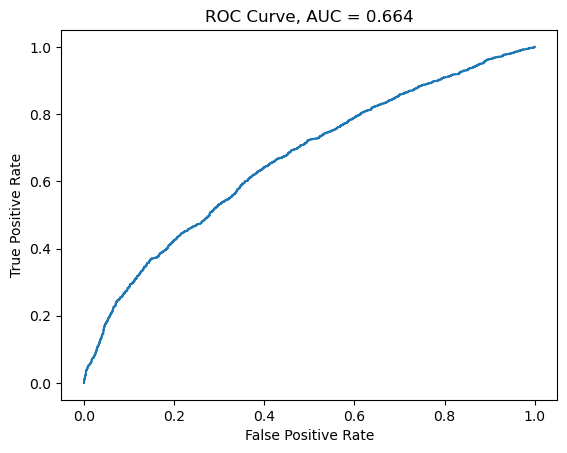

In [21]:
# Predict the probability of the test set
y_proba = pd.DataFrame(clf_e_lr0.predict_proba(X_test)[:, 1], columns=["deceased"])
# Plot the ROC curve
curve = metrics.roc_curve(y_test, y_proba)
# Print the AUC score
print(metrics.roc_auc_score(y_test, y_proba))
plt.plot(curve[0], curve[1])
plt.title("ROC Curve, AUC = 0.664")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In the table below, I show the the coefficients and the features ranked by the absolute value of the coefficient in the best LR model on the test set. The coefficients are the weights of the features in the model. The larger the absolute value of the coefficient, the more important the feature is in the model.

At the very first glance, some of the results seem odd. I will explain the most important 5 features below, citing relevant academic literature to support my explanation.

First, married is the most important feature in determining mortality. Sociological literature since <a href= "https://www.google.com/books/edition/Emile_Durkheim_on_Morality_and_Society/TNLgGJZpDPUC?hl=en&gbpv=0">(Durkheim, 1973)</a> and subsequent sociological findings such as <a href= "https://doi.org/10.2307/2061670">(Waite, 1995)</a> and <a href= "https://www.google.com/books/edition/The_Case_for_Marriage/6_xvDwAAQBAJ?hl=en&gbpv=0">(Waite and Gallagher, 2001)</a> has extensively demonstrated the protective effect of marriage on mortality. Having a strong social connection through marriage will improve support received in the inherent marital relationship, a more institutionalized egocentric social network, better financial security, and better health behaviors <a href= "https://doi.org/10.1016/j.jhealeco.2004.03.002">(Gardner and Oswald, 2004)</a>.

The second most important feature is the race. There is no causal mechanism directly links race to mortality. Hence, this coefficient simply reflects more on the correlation between race and mortality. The intermediate moderators in the correlation includes socioeconomic status, access to health insurance, education, and institutional racism <a href= "http://jpscanlan.com/images/Race_and_Mortality.pdf">(Scanlan, 2000</a><a href= "https://doi.org/10.1016/j.socscimed.2004.11.056">; Shi et al., 2004)</a>.

The third most important feature is smoking. The coeffient seems odd as being a current smoker seems to be negatively correlated with mortality risks. This might becuase of two reasons 1) despite the extensive medical literature on the negative health effects of smoking <a href= "https://doi.org/10.1093/jnci/djy041">(Tindle et al., 2018)</a>, there are many confounders in the association that may be included in the predictive model <a href= "https://doi.org/10.1001/jama.1983.03330400045023">(see Garrison et al., 1983</a> and <a href= "https://doi.org/10.1001/jama.1983.03330400045023">(see Puskin, 2003)</a> 2) the question asks for the current smokers and those who are at high-risks of dying from smoking may have been advised to quit smoking by their doctors <a href= "https://thorax.bmj.com/content/55/12/987.short">(West et al, 2000)</a>. Hence, the current smokers in the dataset are those who are less likely to die from smoking.

The fourth most important feature is sex. Its coefficient also seems odd as the concensus in the field of demography is that the males are more likely to die early compared to females with lower Life Expectancy <a href= "https://www.proquest.com/openview/671e5ff1675f79c8e1b3eb4e1cbc6756/1?cbl=46838&pq-origsite=gscholar">(Luy et al, 214)</a>. However, the reason for the negative association might also be attributed to the control of other health behavioral confounders. For instance, males are more likely to die may because they smoke and drink alcohol more.

The fifth most important feature is ever getting drunk of alcohol. The coefficient also seems odd as the medical literature extensively document the adverse health consequences of getting drunk. This might because of selection bias that those who had never gotten drunk are having other health conditions limiting their ability to drink alcohol and hence, they are more likely to die.

In [22]:
clf_e_lr0.best_estimator_.coef_
clf_e_lr0.best_estimator_.intercept_
clf_e_lr0.best_estimator_.feature_names_in_

equation = pd.concat([pd.DataFrame(clf_e_lr0.best_estimator_.feature_names_in_,
                                   columns=["Features"]),
                      pd.DataFrame(clf_e_lr0.best_estimator_.coef_.T,
                                   columns=["Coef"])], axis=1)
# Sort the features by the absolute value of the coefficient
equation.sort_values(by="Coef", key=abs, ascending=False).round(3)

,Features,Coef
14,Married,-0.484
19,Race_White,0.282
12,Smoking,-0.268
18,Sex_Male,-0.217
13,Drunk Alcohol,-0.195
17,Functional Limitations,0.165
9,Hypertension,0.159
11,Arthritis,0.137
15,Children Nearby,0.103
2,Education Yrs,-0.091


##### **Model Evaluation on Neural Network**

I fit the neural network model with the two sets of parameters identified earlier in the parameter tuning process on the test set. We could see that both parameters have around 0.01 difference in the accuracy score on the training and the testing set. The second set of parameters maximzing AUC_ROC {'activation': 'identity', 'alpha': 0, 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001} has a slightly higher accuracy score on the training and testing set when compared to the corresponding values in the model using the set of parameters maximizing the precision. Hence, I will use the second set of parameters to evaluate the model performance on the test set.

In [23]:
# Take the best model based on the precision
clf_e_nn0 = records_nn['precision']
# Print the performance on the training set
print("Performence on train set",
      metrics.accuracy_score(clf_e_nn0.predict(X_train), y_train))
# Predict the test set
y_pred_nn0 = pd.DataFrame(clf_e_nn0.predict(X_test), columns=["deceased"])
# Print the performance on the test set
print("Performence on test set", metrics.accuracy_score(y_pred_nn0, y_test))

Performence on train set 0.622638326585695
Performence on test set 0.6154819124715406


In [24]:
# Take the best model based on the AUC_ROC
clf_e_nn1 = records_nn['roc_auc']
# Print the performance on the training set
print("Performence on train set",
      metrics.accuracy_score(clf_e_nn1.predict(X_train), y_train))
# Predict the test set
y_pred_nn1 = pd.DataFrame(clf_e_nn1.predict(X_test), columns=["deceased"])
# Print the performance on the test set
print("Performence on test set", metrics.accuracy_score(y_pred_nn1, y_test))

Performence on train set 0.6346997300944669
Performence on test set 0.6253478370857577


For the best NN model, the classfication report shows that the model, compared to the logistic regression model, has lower F1 score on the alive class and better F1 score on the deceased class. It has also got better accuracy. This is ideal for the purpose of this project in distinguishing the deceased class and provide good accuracy. Hence, overall, I would argue that NN model has better performance overall than the logistic regression model.

In [25]:
print(metrics.classification_report(y_test, y_pred_nn1))

              precision    recall  f1-score   support

         0.0       0.64      0.69      0.66      2115
         1.0       0.61      0.55      0.58      1838

    accuracy                           0.63      3953
   macro avg       0.62      0.62      0.62      3953
weighted avg       0.62      0.63      0.62      3953



When comparing the AUC_ROC scores of the two models, we could see that the NN model has a similar AUC_ROC score and confusion matrix as the logistic regression model.

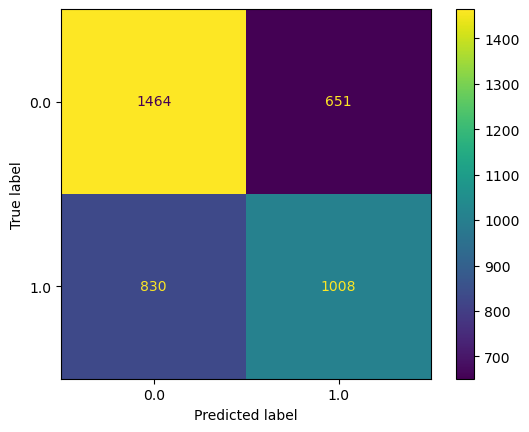

In [26]:
cm_nn1 = metrics.confusion_matrix(y_test, y_pred_nn1)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_nn1,
                                      display_labels=clf_e_nn1.classes_)
disp.plot()

0.6637676629700799


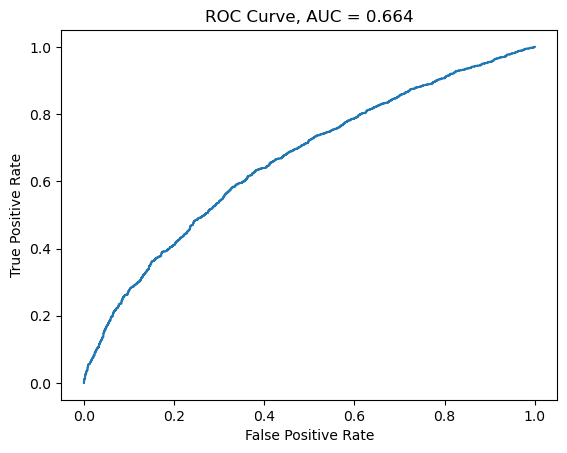

In [27]:
# Predict the probability of the test set
y_proba = pd.DataFrame(clf_e_nn1.predict_proba(X_test)[:, 1], columns=["deceased"])
# Plot the ROC curve
curve = metrics.roc_curve(y_test, y_proba)
# Print the AUC score
print(metrics.roc_auc_score(y_test, y_proba))
plt.plot(curve[0], curve[1])
plt.title("ROC Curve, AUC = 0.664")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

While some argue that the weights of the features in the neural networks are not directly comparable to the coefficients in the logistic regression model and it is difficult to directly interpret the coefficients in the neural networks, the best performing parameter in the HRS dataset is a special case. 

Input -> activation = identity -> hidden -> activation = identity -> output

The activation function that performs the best is identity and there is only one hidden layer. This means that the neural network is equivalent to the logistic regression model. Hence, the absolute ranking of the features is the same as the logistic regression model. The only difference is that the coefficients are the opposite. This is because the activation function is identity, which means that the output of the hidden layer is the same as the input of the output layer. Hence, there are only two layers in the neural network model:

Layer 0: input -> hidden

Layer 1: hidden -> output

Hence, the coefficients of the features in the neural network are the product of the coefficients in the two layers. The coefficients in the first layer are the weights of the features in the input layer and the coefficients in the second layer are the weights of the features in the hidden layer. Based on the final calculated coefficient of the features, we could see that their ranking, absolute values, and signs are similar to the logistic regression model.

In [28]:
# Show the equation of the best NN model
equation_nn = pd.concat([pd.DataFrame(clf_e_nn1.best_estimator_.feature_names_in_,
                                        columns=["Features"]),
                         pd.DataFrame(clf_e_nn1.best_estimator_.coefs_[0],
                                        columns=["Coef_layer0"]),
                         pd.DataFrame(clf_e_nn1.best_estimator_.coefs_[1],
                                        columns=["Coef_layer1"])], axis=1)
equation_nn = equation_nn.sort_values(by="Coef_layer0", key=abs,
                                      ascending=False)
equation_nn["Coef_layer1"] = equation_nn["Coef_layer1"].ffill()
equation_nn["Coef_layer1"] = equation_nn["Coef_layer1"].bfill()
equation_nn["Coef"] = equation_nn["Coef_layer0"] * equation_nn["Coef_layer1"]
equation_nn.round(3)

,Features,Coef_layer0,Coef_layer1,Coef
14,Married,0.398,-0.954,-0.380
19,Race_White,-0.308,-0.954,0.294
17,Functional Limitations,-0.289,-0.954,0.276
12,Smoking,0.289,-0.954,-0.275
18,Sex_Male,0.220,-0.954,-0.210
13,Drunk Alcohol,0.198,-0.954,-0.189
9,Hypertension,-0.163,-0.954,0.156
15,Children Nearby,-0.140,-0.954,0.134
11,Arthritis,-0.097,-0.954,0.092
2,Education Yrs,0.096,-0.954,-0.091


##### **Model Evaluation on KNN**

Similar to the steps taken earlier in model evaluation, I fit the selected two sets of model parameters on the testing data to get the accuracy. The differences between training and testing accuracy and between models seem much larger than the differences seen in the LR. The model with the parameters {'n_neighbors': 5, 'p': 1, 'weights': 'distance'} performs the best in terms of accuracy score on the test set (though worse on the train set), indicating less overfitting. Hence, I will use this set of parameters to evaluate the model performance on the test set.

In [29]:
# Take the best model based on the f1 score
clf_e_knn0 = records_knn['f1']
# Print the performance on the training set
print("Performence on train set",
      metrics.accuracy_score(clf_e_knn0.predict(X_train), y_train))
# Predict the test set
y_pred_knn0 = pd.DataFrame(clf_e_knn0.predict(X_test), columns=["deceased"])
# Print the performance on the test set
print("Performence on test set", metrics.accuracy_score(y_pred_knn0, y_test))


Performence on train set 0.998144399460189
Performence on test set 0.6063749051353402


In [30]:
# Take the best model based on the precision
clf_e_knn1 = records_knn['precision']
# Print the performance on the training set
print("Performence on train set",
      metrics.accuracy_score(clf_e_knn1.predict(X_train), y_train))
# Predict the test set
y_pred_knn1 = pd.DataFrame(clf_e_knn1.predict(X_test), columns=["deceased"])
# Print the performance on the test set
print("Performence on test set", metrics.accuracy_score(y_pred_knn1, y_test))


Performence on train set 0.6427968960863698
Performence on test set 0.630407285605869


For the best parameter set on the training data, I show the classification report below. Again, there are similar issues as the LR model. The model has a high precision, recall, F1 score on the alive class, but a low on the deceased class. However, the model has a higher F1 score on the alive class than the LR model, indicating the model could better distinguish the alive class and thus identifying the protective factors than the LR model. When compared to the NN model, the KNN has lower F1 score on the deceased class. Hence, it could not distinguish the deceased class as well as the NN model.

In [31]:
print(metrics.classification_report(y_test, y_pred_knn1))

              precision    recall  f1-score   support

         0.0       0.62      0.79      0.70      2115
         1.0       0.65      0.45      0.53      1838

    accuracy                           0.63      3953
   macro avg       0.64      0.62      0.61      3953
weighted avg       0.63      0.63      0.62      3953



In terms of AUC_ROC score, the KNN model has the slightly the highest score among the three models. This indicates that the model can best distinguish the deceased and alive classes well. However, the difference between the AUC_ROC scores of the three models is not large.

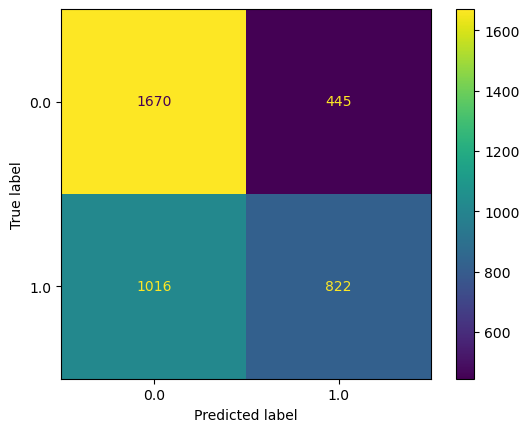

In [32]:
cm_knn1 = metrics.confusion_matrix(y_test, y_pred_knn1)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_knn1,
                                      display_labels=clf_e_knn1.classes_)
disp.plot()

 The model has a lower AUC_ROC score than the LR model, indicating that the model cannot distinguish the deceased and alive classes as well as the LR model.

0.6553514329739645


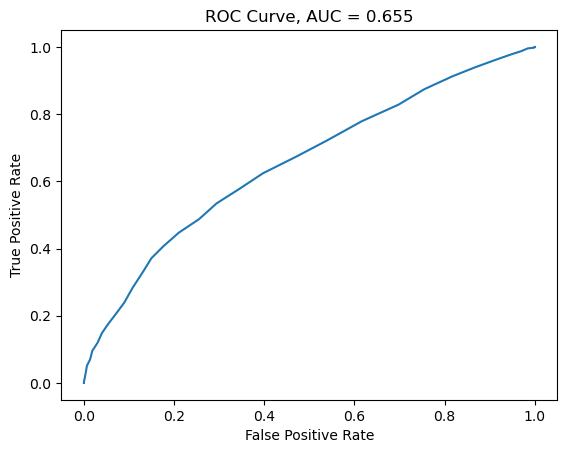

In [33]:
# Predict the probability of the test set
y_proba = pd.DataFrame(clf_e_knn1.predict_proba(X_test)[:, 1], columns=["deceased"])
# Plot the ROC curve
curve = metrics.roc_curve(y_test, y_proba)
# Print the AUC score
print(metrics.roc_auc_score(y_test, y_proba))
plt.plot(curve[0], curve[1])
plt.title("ROC Curve, AUC = 0.655")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### **Error Analysis**

Error analysis is a process of identifying the errors made by the model and the reasons behind the errors. This process is important in improving the model performance. In this section, I will analyze the errors made by the three models and the reasons behind the errors. In doing so, I have created a function that takes in the model, the test set and returns the dataframe of the errors made by the model.

In [34]:
def display_wrong_sample(clf_e, X_test, y_test):
    '''
    Take in a classifier, the test data and the test target, and return a
    dataframe of the wrong predictions
    
    Input:
        clf_e: a classifier
        X_test: the test data
        y_test: the test target
    
    Output:
        rf_wrong: a dataframe of the wrong predictions
    '''
    y_pred_rf = pd.DataFrame(clf_e.predict(X_test), columns=["deceased"])
    X_wrong_rf = X_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
        y_pred_rf['deceased'] != y_test.reset_index(inplace=False)['deceased']
        ]
    y_wrong_rf = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
        y_pred_rf['deceased'] != y_test.reset_index(inplace=False)['deceased']
        ]
    rf_wrong = pd.concat([y_wrong_rf, X_wrong_rf], axis=1)
    return rf_wrong

When comparing between models on the errors, one could easily notice that Neural Network and Logistic Regression make similar errors becuase they have similar feature importance and model performance, while KNN makes different errors. This is because KNN is a non-parametric model and it does not have a clear interpretation of the feature importance. Hence, the errors made by KNN are not as interpretable as the errors made by the other two models.

In the following sections, I will analyze the errors made by the three models and the reasons behind the errors.

The errors made by the LR and NN models are as follows:
- False positives: divorced/widowed (i.e., married = False) older adults who, however, have children nearby and many grandchildren -> still having closely connected social networks protecting them from death
- False negatives: married older adults who, however, have very few grandchildren and no close relatives nearby

Because KNN is a non-parametric model, it does not have a clear interpretation of the feature importance. Analyzing the errors made by the KNN model is not as interpretable as the errors made by the other two models. However, we could still see that the errors made by the KNN model are different from the errors made by the other two models. This allows us to potentially identify features that were important for the KNN model but not for the other two models. The errors made by the KNN model are as follows:

- False positives: poor and divorced older adults who, however, have very good health behaviors (e.g., smoking, drinking, and activities) and self-rated health
- False negatives: educated older adults who don't smoke or get drunk but are very obese and have low social participation (e.g., religious groups or volunteering)

Hence, I find, in addition to considering marital status, children/grandchildren, and close relatives, the KNN model also considers household asset, health behaviors, self-rated health, and obesity as important features in predicting mortality.

In [35]:
wrong_sample_lr = display_wrong_sample(clf_e_lr0, X_test, y_test)
wrong_sample_lr.head()

,deceased,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age,...,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex_Male,Race_White
2,0.0,193.0,4.0,14.0,1.0,20.000000,0.00000,1.0,0.0,66.0,...,False,True,False,False,False,False,True,True,True,False
3,1.0,125.0,3.0,14.0,1.0,7.000000,45.70395,1.0,0.0,63.0,...,False,True,False,True,True,True,True,False,False,False
7,0.0,175.0,2.0,15.0,1.0,6.657524,45.70395,1.0,0.0,84.0,...,False,True,False,True,False,True,False,True,False,True
10,0.0,135.0,2.0,12.0,3.0,6.657524,0.00000,1.0,0.0,83.0,...,False,True,False,False,True,True,True,False,True,True
14,0.0,120.0,1.0,9.0,1.0,1.000000,0.00000,1.0,0.0,80.0,...,False,False,False,True,False,True,False,False,False,True


In [36]:
wrong_sample_nn = display_wrong_sample(clf_e_nn1, X_test, y_test)
wrong_sample_nn.head()

,deceased,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age,...,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex_Male,Race_White
2,0.0,193.0,4.0,14.0,1.0,20.000000,0.00000,1.0,0.0,66.0,...,False,True,False,False,False,False,True,True,True,False
3,1.0,125.0,3.0,14.0,1.0,7.000000,45.70395,1.0,0.0,63.0,...,False,True,False,True,True,True,True,False,False,False
7,0.0,175.0,2.0,15.0,1.0,6.657524,45.70395,1.0,0.0,84.0,...,False,True,False,True,False,True,False,True,False,True
10,0.0,135.0,2.0,12.0,3.0,6.657524,0.00000,1.0,0.0,83.0,...,False,True,False,False,True,True,True,False,True,True
14,0.0,120.0,1.0,9.0,1.0,1.000000,0.00000,1.0,0.0,80.0,...,False,False,False,True,False,True,False,False,False,True


In [37]:
wrong_sample_knn = display_wrong_sample(clf_e_knn1, X_test, y_test)
wrong_sample_knn.head()

,deceased,Weight (Pounds),Self-Rated Health,Education Yrs,Religion Importance,Number of Grandchildren,Hours of Volunteering,Number of Times Socializing,Wealth,Age,...,Diabetes,Arthritis,Smoking,Drunk Alcohol,Married,Children Nearby,Relatives Nearby,Functional Limitations,Sex_Male,Race_White
3,1.0,125.0,3.0,14.0,1.0,7.000000,45.70395,1.0,0.0,63.0,...,False,True,False,True,True,True,True,False,False,False
8,1.0,170.0,2.0,5.0,1.0,10.000000,720.00000,1.0,0.0,78.0,...,False,True,False,False,False,False,False,False,True,False
10,0.0,135.0,2.0,12.0,3.0,6.657524,0.00000,1.0,0.0,83.0,...,False,True,False,False,True,True,True,False,True,True
14,0.0,120.0,1.0,9.0,1.0,1.000000,0.00000,1.0,0.0,80.0,...,False,False,False,True,False,True,False,False,False,True
15,1.0,230.0,3.0,12.0,1.0,4.000000,25.00000,0.0,0.0,55.0,...,False,True,False,False,True,True,False,False,False,True


### Conclusion

Within the project above, I have used the HRS dataset to predict mortality in the next 14 years using the baseline characteristics in 2002. I have also discussed the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms. Specifically, I have used a Logistic Regression Classifer, a Neural Network Classifer, and a KNN Classider. The following was the pipeline of the project:

1. Exploratory Data Analysis & Data Preprocessing: I have merged the files of the HRS dataset of each wave (e.g., 2002) into one dataframe. Then, I have checked whether the outcome variable is balanced. After checking the balance of the outcome variable and the missingness of the predictors, I went ahead to preprocess the data for the analysis by 1) imputing the missing values separately for continuous and categorical variables 2) construct some variables based on multiple other variables 3) scaling the continuous variables.
2. Pipeline: Feature Selection, Parameter Tuning, and Model Training: I have used the pipeline to select the features, tune the parameters, and validate the data. The pipeline used the following algorithms to train the model: logistic regression, neural network, and KNN.
3. Model Evaluation (On Test Set) and Error Analysis: I have evaluated the models on the test set and analyzed the errors of the models. I have also discussed the social and demographic characteristics of the cases whose disposition statuses were either wrongly predicted as death or alive by the algorithms.

Overall the findings will serve important purposes for public health practitioners in understanding the risk and protective factors of mortality in the aging process. When comparing between model performances in accurately predicting mortality, the neural network model has the best performance. However, it is computationally intensive. Therefore, the logistic regression model is the best model for predicting mortality in the aging process. The logistic regression model has relatively good performance in terms of the F1 score and the AUC. The logistic regression model is also the most interpretable model as it can provide the odds ratio of the predictors. Hence, it can be used to explain the model to the stakeholders. The logistic regression model is also the most efficient model as it is the fastest model to train and predict and the most stable model as it is the least likely to overfit the data among the three algorithms.


Future avenues of research include the following (as I will collaborate with Zejian on our conference presentation this October):
1. Comparing and contrasting the differences in the important predictors of mortality between the NSHAP, WLS and HRS datasets.
2. Proposing the best model for predicting mortality in the aging process based on the differences in the important predictors of mortality between the NSHAP, WLS and HRS datasets.